# 1. Import necessary Libraries

In [198]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
! pip install -i https://test.pypi.org/simple/ my-krml-24587139

Looking in indexes: https://test.pypi.org/simple/


In [202]:
import pandas as pd
import numpy as np

# 2. Load Dataset

In [204]:
df_train_cleaned = pd.read_csv('../data/processed/df_train_cleaned.csv')
df_test_cleaned = pd.read_csv('../data/processed/df_test_cleaned.csv')

In [206]:
from my_krml_24587139.data.sets import pop_target

In [208]:
df_train_cleaned, target = pop_target(df_train_cleaned, 'drafted')

# 3. Standardize Data

In [210]:
import pickle

In [212]:
with open('../models/scaler.joblib', 'rb') as f:
    scaler = pickle.load(f)

In [214]:
print(df_train_cleaned.shape)
print(df_test_cleaned.shape)

(56091, 54)
(4970, 54)


In [216]:
df_train_cleaned = pd.DataFrame(scaler.fit_transform(df_train_cleaned), columns=df_train_cleaned.columns)
df_test_cleaned = pd.DataFrame(scaler.fit_transform(df_test_cleaned), columns=df_test_cleaned.columns)

# 4. Splitting Data

In [218]:
from my_krml_24587139.data.sets import split_sets_at1

In [220]:
X_train, X_val, y_train, y_val = split_sets_at1(df_train_cleaned, target, test_ratio=0.2)

In [222]:
print(X_train.shape)
print(y_train.shape)
print(df_test_cleaned.shape)

(44872, 54)
(44872,)
(4970, 54)


In [224]:
type(y_train)

pandas.core.series.Series

In [226]:
X_test = df_test_cleaned.copy()

# 5. Apply PCA for Dimensionality Reduction

In [228]:
from my_krml_24587139.data.sets import apply_pca

In [230]:
X_train = apply_pca(X_train , n_components = 0.99)
X_val = apply_pca(X_val , n_components = 0.99)
X_test = apply_pca(X_test , n_components = 0.99)

In [232]:
from my_krml_24587139.data.sets import save_sets

In [233]:
save_sets(X_train, y_train, X_val, y_val, X_test, path='../data/processed/')


In [234]:
type(y_train)

pandas.core.series.Series

# 6. Train SVM 

#### 6.1. With Default Parameters

In [235]:
from sklearn.svm import SVC

In [236]:
svc_1 = SVC(probability=True)

In [237]:
clf = svc_1.fit(X_train, y_train)

In [238]:
y_train_preds = svc_1.predict(X_train)
y_val_preds = svc_1.predict(X_val)

In [239]:
from my_krml_24587139.models.performance import print_regressor_scores_at1

In [240]:
print_regressor_scores_at1(X = X_train, y_actuals=y_train, model = svc_1, set_name='Training')

roc_auc_score for Training data: 0.9398137011634815


In [241]:
print_regressor_scores_at1(X = X_val, y_actuals=y_val, model = svc_1, set_name='Validation')

roc_auc_score for Validation data: 0.6412952239877907


In [242]:
from my_krml_24587139.models.performance import predict_probability

In [243]:
y_score_val = predict_probability(X_val, clf)

In [244]:
y_score_val

array([0.00905644, 0.00360325, 0.00096765, ..., 0.01918495, 0.00738618,
       0.01087659])

In [245]:
player_id = pd.read_csv("../data/processed/player_id.csv")
player_id = player_id.drop(player_id.columns[0], axis=1)

In [246]:
y_score_test = predict_probability(X_test, clf)

In [247]:
y_score_test

array([0.01019238, 0.00493089, 0.00799844, ..., 0.00689752, 0.00692363,
       0.00888212])

In [248]:
df_scores = pd.concat({'': player_id, 'drafted': pd.Series(y_score_val)}, axis = 1)
df_scores

,,drafted
,player_id,0
0,cf302b4d-84f7-4124-a25d-a75eed31978b,0.009056
1,f91837cd-4f49-4b70-963d-aeb82c6ce3da,0.003603
2,53ec2a29-1e7d-4c6d-86d7-d60d02af8916,0.000968
3,32402798-471c-4a54-8cb4-29cd95199014,0.019276
4,73b960f9-27b8-4431-9d23-a760e9bbc360,0.005360
...,...,...
11214,NaN,0.005194
11215,NaN,0.006786
11216,NaN,0.019185


In [249]:
df_scores = pd.concat({'': player_id, 'drafted': pd.Series(y_score_test)}, axis = 1)
df_scores

,,drafted
,player_id,0
0,cf302b4d-84f7-4124-a25d-a75eed31978b,0.010192
1,f91837cd-4f49-4b70-963d-aeb82c6ce3da,0.004931
2,53ec2a29-1e7d-4c6d-86d7-d60d02af8916,0.007998
3,32402798-471c-4a54-8cb4-29cd95199014,0.014753
4,73b960f9-27b8-4431-9d23-a760e9bbc360,0.003824
...,...,...
4965,a25ee55f-02a3-4f8e-8194-a5f427e14e7c,0.018341
4966,d0d9f45e-7b01-44b3-8d40-514ec338611d,0.009436
4967,f8df22c4-1602-4fab-896d-8820951aae2f,0.006898


#### 6.1.1 Viewing ROC Results

In [250]:
!pip install matplotlib

In [251]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [252]:
y_score_train = predict_probability(X_train, clf)

In [253]:
fpr, tpr, _ = metrics.roc_curve(y_train,  y_score_train)

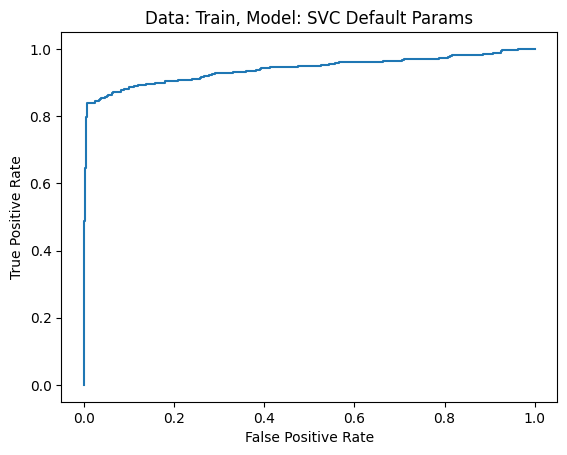

In [254]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Data: Train, Model: SVC Default Params')

plt.savefig('../reports/figures/Train_SVC_Weight_default.png')

In [255]:
y_score_val = predict_probability(X_val, clf)

In [256]:
fpr, tpr, _ = metrics.roc_curve(y_val,  y_score_val)

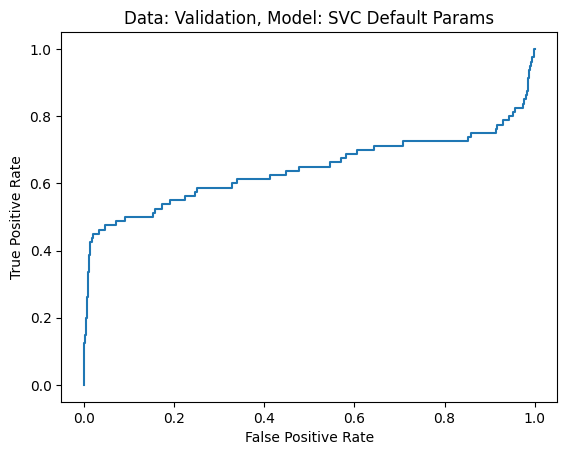

In [257]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Data: Validation, Model: SVC Default Params')

plt.savefig('../reports/figures/Validation_SVC_Default.png')

#### 6.2. With class_weight='balanced'

In [258]:
svc_2 = SVC(probability=True, class_weight='balanced')

In [259]:
clf = svc_2.fit(X_train, y_train)

In [260]:
y_train_preds = svc_2.predict(X_train)
y_val_preds = svc_2.predict(X_val)

In [261]:
print_regressor_scores_at1(X = X_train, y_actuals=y_train, model = svc_2, set_name='Training')

roc_auc_score for Training data: 0.9947329119583902


In [262]:
print_regressor_scores_at1(X = X_val, y_actuals=y_val, model = svc_2, set_name='Validation')

roc_auc_score for Validation data: 0.8466233503905197


In [263]:
y_score_val = predict_probability(X_val, clf)

In [264]:
y_score_val

array([0.00091827, 0.00058592, 0.00020999, ..., 0.0034199 , 0.00021498,
       0.00034755])

In [265]:
player_id = pd.read_csv("../data/processed/player_id.csv")
player_id = player_id.drop(player_id.columns[0], axis=1)

In [266]:
y_score_test = predict_probability(X_test, clf)

In [267]:
y_score_test

array([0.00180548, 0.00017264, 0.00026479, ..., 0.0004364 , 0.00042236,
       0.0037367 ])

In [268]:
df_scores = pd.concat({'': player_id, 'drafted': pd.Series(y_score_val)}, axis = 1)
df_scores

,,drafted
,player_id,0
0,cf302b4d-84f7-4124-a25d-a75eed31978b,0.000918
1,f91837cd-4f49-4b70-963d-aeb82c6ce3da,0.000586
2,53ec2a29-1e7d-4c6d-86d7-d60d02af8916,0.000210
3,32402798-471c-4a54-8cb4-29cd95199014,0.004040
4,73b960f9-27b8-4431-9d23-a760e9bbc360,0.000146
...,...,...
11214,NaN,0.005140
11215,NaN,0.000088
11216,NaN,0.003420


In [269]:
df_scores = pd.concat({'': player_id, 'drafted': pd.Series(y_score_test)}, axis = 1)
df_scores

,,drafted
,player_id,0
0,cf302b4d-84f7-4124-a25d-a75eed31978b,0.001805
1,f91837cd-4f49-4b70-963d-aeb82c6ce3da,0.000173
2,53ec2a29-1e7d-4c6d-86d7-d60d02af8916,0.000265
3,32402798-471c-4a54-8cb4-29cd95199014,0.010199
4,73b960f9-27b8-4431-9d23-a760e9bbc360,0.000143
...,...,...
4965,a25ee55f-02a3-4f8e-8194-a5f427e14e7c,0.005312
4966,d0d9f45e-7b01-44b3-8d40-514ec338611d,0.001047
4967,f8df22c4-1602-4fab-896d-8820951aae2f,0.000436


#### 6.2.1 Viewing ROC Results

In [270]:
y_score_train = predict_probability(X_train, clf)

In [271]:
fpr, tpr, _ = metrics.roc_curve(y_train,  y_score_train)

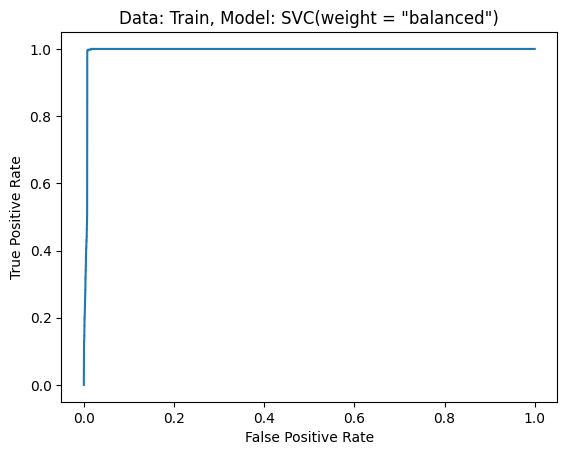

In [272]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Data: Train, Model: SVC(weight = "balanced")')

plt.savefig('../reports/figures/Train_SVC_Weight_balanced.png')

In [273]:
y_score_val = predict_probability(X_val, clf)

In [274]:
fpr, tpr, _ = metrics.roc_curve(y_val,  y_score_val)

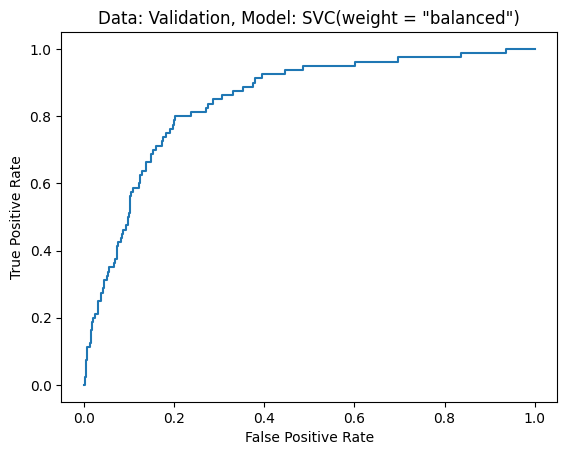

In [275]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Data: Validation, Model: SVC(weight = "balanced")')

plt.savefig('../reports/figures/Validation_SVC_Weight_balanced.png')

# 7. Saving The Best Model

In [276]:
from joblib import dump

dump(svc_2,  '../models/svc_week2.joblib')

['../models/svc_week2.joblib']